In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Cyclegan

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
import gzip
torch.cuda.set_device(2)

In [3]:
from cyclegan import *

In [4]:
#! wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip

In [5]:
PATH = Path('data/cyclegan/horse2zebra')
TRAIN_A,TRAIN_B = 'trainA','trainB'
TEST_A,TEST_B = 'testA','testB'
IMGA_PATH = PATH/TRAIN_A
IMGB_PATH = PATH/TRAIN_B

In [22]:
CSV_A,CSV_B = PATH/'a.csv',PATH/'b.csv'
bs=4

In [7]:
def list_files(path, csv):
    files = path.glob('*.jpg')
    with csv.open('w') as fo:
        for f in files: fo.write(f'{f.name},0\n')

list_files(IMGA_PATH, CSV_A)
list_files(IMGB_PATH, CSV_B)

In [23]:
aug_tfms = [RandomFlip()]
tfms = tfms_from_stats(inception_stats, 256, max_zoom=1.1, aug_tfms=aug_tfms)
mda = ImageClassifierData.from_csv(PATH, TRAIN_A, CSV_A, tfms=tfms, val_idxs=[0], bs=bs)
mdb = ImageClassifierData.from_csv(PATH, TRAIN_B, CSV_B, tfms=tfms, val_idxs=[0], bs=bs)

In [24]:
def show_img(im, ax=None, figsize=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [25]:
denorm = mda.trn_ds.denorm

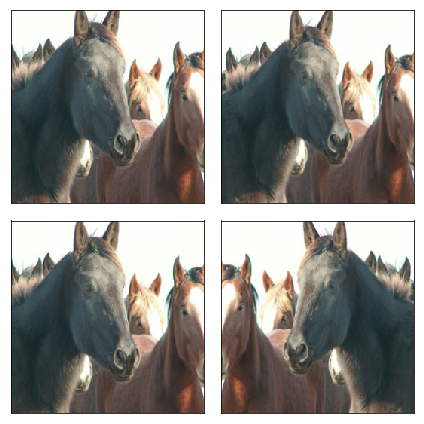

In [10]:
fig,axes = plt.subplots(2,2, figsize=(6,6))
for i,ax in enumerate(axes.flat):
    x,_ = next(iter(mda.aug_dl))
    show_img(denorm(x)[0], ax)
fig.tight_layout()

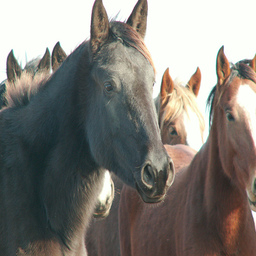

In [11]:
Image.open(PATH/mda.val_ds.fnames[0])

In [26]:
num_resnet = 6
ndf=64
ngf=32
# lr=0.0008
lr=0.0002
beta1,beta2 = 0.5,0.999

In [27]:
G_A = Generator(3, ngf, 3, num_resnet).cuda()
G_B = Generator(3, ngf, 3, num_resnet).cuda()
D_A = Discriminator(3, ndf, 1).cuda()
D_B = Discriminator(3, ndf, 1).cuda()
G_A.normal_weight_init(mean=0.0, std=0.02)
G_B.normal_weight_init(mean=0.0, std=0.02)
D_A.normal_weight_init(mean=0.0, std=0.02)
D_B.normal_weight_init(mean=0.0, std=0.02)

In [28]:
MSE_loss = nn.MSELoss().cuda()
L1_loss = nn.L1Loss().cuda()

G_optimizer = optim.Adam(itertools.chain(G_A.parameters(), G_B.parameters()), lr=lr, betas=(beta1, beta2))
D_A_optimizer = optim.Adam(D_A.parameters(), lr=lr, betas=(beta1, beta2))
D_B_optimizer = optim.Adam(D_B.parameters(), lr=lr, betas=(beta1, beta2))

In [29]:
class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images.data:
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:
                    random_id = random.randint(0, self.pool_size-1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return_images = Variable(torch.cat(return_images, 0))
        return return_images

In [30]:
num_pool = 50
fake_A_pool = ImagePool(num_pool)
fake_B_pool = ImagePool(num_pool)

In [31]:
decay_epoch=100
lambdaA,lambdaB = 10,10

In [32]:
def train(num_epochs):
    for epoch in range(num_epochs):
        train_data_loader_A = iter(mda.trn_dl)
        train_data_loader_B = iter(mdb.trn_dl)

        # learning rate decay
        if (epoch + 1) > decay_epoch:
            D_A_optimizer.param_groups[0]['lr'] -= lr / (num_epochs - decay_epoch)
            D_B_optimizer.param_groups[0]['lr'] -= lr / (num_epochs - decay_epoch)
            G_optimizer.param_groups[0]['lr'] -= lr / (num_epochs - decay_epoch)

        # training
        for real_A, real_B in tqdm(zip(train_data_loader_A, train_data_loader_B), total=len(mda.trn_dl)):
            # input image data
            real_A = Variable(real_A[0].cuda())
            real_B = Variable(real_B[0].cuda())

            # Train generator G
            fake_B = G_A(real_A)
            D_B_fake_decision = D_B(fake_B)
            G_A_loss = MSE_loss(D_B_fake_decision, Variable(torch.ones(D_B_fake_decision.size()).cuda()))

            # forward cycle loss
            recon_A = G_B(fake_B)
            cycle_A_loss = L1_loss(recon_A, real_A) * lambdaA

            # B -> A
            fake_A = G_B(real_B)
            D_A_fake_decision = D_A(fake_A)
            G_B_loss = MSE_loss(D_A_fake_decision, Variable(torch.ones(D_A_fake_decision.size()).cuda()))

            # backward cycle loss
            recon_B = G_A(fake_A)
            cycle_B_loss = L1_loss(recon_B, real_B) * lambdaB

            # Back propagation
            G_loss = G_A_loss + G_B_loss + cycle_A_loss + cycle_B_loss
            G_optimizer.zero_grad()
            G_loss.backward()
            G_optimizer.step()

            # Train discriminator D_A
            D_A_real_decision = D_A(real_A)
            D_A_real_loss = MSE_loss(D_A_real_decision, Variable(torch.ones(D_A_real_decision.size()).cuda()))
            fake_A = fake_A_pool.query(fake_A)
            D_A_fake_decision = D_A(fake_A)
            D_A_fake_loss = MSE_loss(D_A_fake_decision, Variable(torch.zeros(D_A_fake_decision.size()).cuda()))

            # Back propagation
            D_A_loss = (D_A_real_loss + D_A_fake_loss) * 0.5
            D_A_optimizer.zero_grad()
            D_A_loss.backward()
            D_A_optimizer.step()

            # Train discriminator D_B
            D_B_real_decision = D_B(real_B)
            D_B_real_loss = MSE_loss(D_B_real_decision, Variable(torch.ones(D_B_real_decision.size()).cuda()))
            fake_B = fake_B_pool.query(fake_B)
            D_B_fake_decision = D_B(fake_B)
            D_B_fake_loss = MSE_loss(D_B_fake_decision, Variable(torch.zeros(D_B_fake_decision.size()).cuda()))

            # Back propagation
            D_B_loss = (D_B_real_loss + D_B_fake_loss) * 0.5
            D_B_optimizer.zero_grad()
            D_B_loss.backward()
            D_B_optimizer.step()

        print('Epoch [%d/%d], D_A_loss: %.4f, D_B_loss: %.4f, G_A_loss: %.4f, G_B_loss: %.4f'
              % (epoch+1, num_epochs, D_A_loss.data[0], D_B_loss.data[0],
                 G_A_loss.data[0], G_B_loss.data[0]))


In [33]:
train(200)

100%|██████████| 267/267 [01:35<00:00,  2.79it/s]
Epoch [1/200], D_A_loss: 0.2037, D_B_loss: 0.2250, G_A_loss: 0.2907, G_B_loss: 0.4249
100%|██████████| 267/267 [01:37<00:00,  2.74it/s]
Epoch [2/200], D_A_loss: 0.1040, D_B_loss: 0.1999, G_A_loss: 0.7573, G_B_loss: 0.3192
100%|██████████| 267/267 [01:37<00:00,  2.75it/s]
Epoch [3/200], D_A_loss: 0.1764, D_B_loss: 0.0979, G_A_loss: 0.7210, G_B_loss: 0.1849
100%|██████████| 267/267 [01:38<00:00,  2.70it/s]
Epoch [4/200], D_A_loss: 0.1517, D_B_loss: 0.1111, G_A_loss: 0.5446, G_B_loss: 0.4291
100%|██████████| 267/267 [01:39<00:00,  2.69it/s]
Epoch [5/200], D_A_loss: 0.2101, D_B_loss: 0.0675, G_A_loss: 0.7677, G_B_loss: 0.2543
100%|██████████| 267/267 [01:39<00:00,  2.69it/s]
Epoch [6/200], D_A_loss: 0.1365, D_B_loss: 0.0835, G_A_loss: 0.4644, G_B_loss: 0.3158
100%|██████████| 267/267 [01:38<00:00,  2.71it/s]
Epoch [7/200], D_A_loss: 0.1305, D_B_loss: 0.1584, G_A_loss: 0.4035, G_B_loss: 0.4178
100%|██████████| 267/267 [01:40<00:00,  2.67it/s

100%|██████████| 267/267 [01:36<00:00,  2.76it/s]
Epoch [61/200], D_A_loss: 0.0861, D_B_loss: 0.1982, G_A_loss: 0.3531, G_B_loss: 0.5482
100%|██████████| 267/267 [01:36<00:00,  2.77it/s]
Epoch [62/200], D_A_loss: 0.1328, D_B_loss: 0.1554, G_A_loss: 0.2483, G_B_loss: 0.4345
100%|██████████| 267/267 [01:36<00:00,  2.75it/s]
Epoch [63/200], D_A_loss: 0.0765, D_B_loss: 0.0918, G_A_loss: 0.4945, G_B_loss: 0.3133
100%|██████████| 267/267 [01:36<00:00,  2.76it/s]
Epoch [64/200], D_A_loss: 0.1385, D_B_loss: 0.1105, G_A_loss: 0.3398, G_B_loss: 0.4284
100%|██████████| 267/267 [01:36<00:00,  2.76it/s]
Epoch [65/200], D_A_loss: 0.0643, D_B_loss: 0.2738, G_A_loss: 0.1300, G_B_loss: 0.6699
100%|██████████| 267/267 [01:36<00:00,  2.76it/s]
Epoch [66/200], D_A_loss: 0.1075, D_B_loss: 0.0917, G_A_loss: 0.8636, G_B_loss: 0.4419
100%|██████████| 267/267 [01:36<00:00,  2.76it/s]
Epoch [67/200], D_A_loss: 0.0633, D_B_loss: 0.1743, G_A_loss: 0.4173, G_B_loss: 0.3672
100%|██████████| 267/267 [01:36<00:00,  2

KeyboardInterrupt: 

In [34]:
test_real_A_data = T(mda.val_ds[0][0]).unsqueeze(0)  # Convert to 4d tensor (BxNxHxW)
test_real_B_data = T(mdb.val_ds[0][0]).unsqueeze(0)

In [35]:
test_real_A = VV(test_real_A_data)
test_fake_B = G_A(test_real_A)
test_recon_A = G_B(test_fake_B)
test_real_B = VV(test_real_B_data)
test_fake_A = G_B(test_real_B)
test_recon_B = G_A(test_fake_A)

In [36]:
test_imgs = [denorm(to_np(o))[0] for o in
    (test_real_A, test_fake_B, test_recon_A, test_real_B, test_fake_A, test_recon_B)]

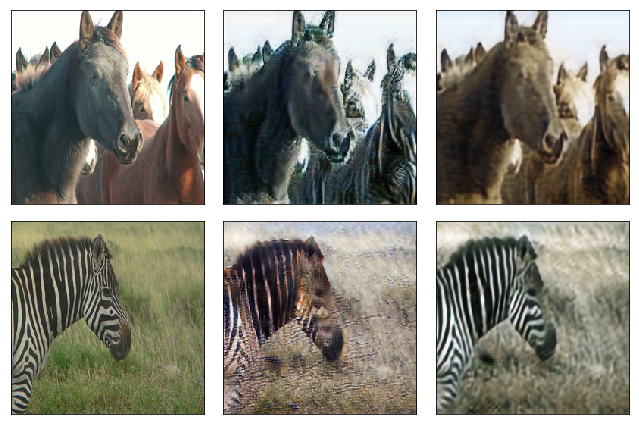

In [37]:
fig,axes = plt.subplots(2,3,figsize=(9,6))
for i,ax in enumerate(axes.flat): show_img(test_imgs[i], ax)
fig.tight_layout()

In [34]:
train(200)

100%|██████████| 1065/1065 [02:32<00:00,  6.97it/s]
Epoch [1/200], D_A_loss: 0.0443, D_B_loss: 0.0339, G_A_loss: 0.4457, G_B_loss: 0.1009
100%|██████████| 1065/1065 [02:32<00:00,  6.99it/s]
Epoch [2/200], D_A_loss: 0.0979, D_B_loss: 0.0567, G_A_loss: 0.6900, G_B_loss: 0.4430
100%|██████████| 1065/1065 [02:35<00:00,  6.84it/s]
Epoch [3/200], D_A_loss: 0.0540, D_B_loss: 0.0776, G_A_loss: 0.7383, G_B_loss: 0.6628
100%|██████████| 1065/1065 [02:34<00:00,  6.88it/s]
Epoch [4/200], D_A_loss: 0.1093, D_B_loss: 0.0232, G_A_loss: 0.2447, G_B_loss: 0.5449
100%|██████████| 1065/1065 [02:34<00:00,  6.88it/s]
Epoch [5/200], D_A_loss: 0.3787, D_B_loss: 0.0388, G_A_loss: 1.0431, G_B_loss: 0.1159
100%|██████████| 1065/1065 [02:35<00:00,  6.87it/s]
Epoch [6/200], D_A_loss: 0.2967, D_B_loss: 0.2454, G_A_loss: 0.3302, G_B_loss: 0.1840
100%|██████████| 1065/1065 [02:34<00:00,  6.87it/s]
Epoch [7/200], D_A_loss: 0.2286, D_B_loss: 0.0386, G_A_loss: 0.4809, G_B_loss: 0.4748
100%|██████████| 1065/1065 [02:34<

100%|██████████| 1065/1065 [02:32<00:00,  7.00it/s]
Epoch [119/200], D_A_loss: 0.0677, D_B_loss: 0.0774, G_A_loss: 0.5132, G_B_loss: 0.6012
100%|██████████| 1065/1065 [02:32<00:00,  6.97it/s]
Epoch [120/200], D_A_loss: 0.0399, D_B_loss: 0.0220, G_A_loss: 0.8241, G_B_loss: 0.5560
100%|██████████| 1065/1065 [02:34<00:00,  6.88it/s]
Epoch [121/200], D_A_loss: 0.1123, D_B_loss: 0.0277, G_A_loss: 0.7086, G_B_loss: 0.7514
100%|██████████| 1065/1065 [02:33<00:00,  6.94it/s]
Epoch [122/200], D_A_loss: 0.0466, D_B_loss: 0.0184, G_A_loss: 0.7893, G_B_loss: 0.7277
100%|██████████| 1065/1065 [02:32<00:00,  6.96it/s]
Epoch [123/200], D_A_loss: 0.0357, D_B_loss: 0.1421, G_A_loss: 0.4728, G_B_loss: 1.1230
100%|██████████| 1065/1065 [02:33<00:00,  6.93it/s]
Epoch [124/200], D_A_loss: 0.0276, D_B_loss: 0.1048, G_A_loss: 0.5904, G_B_loss: 0.7563
100%|██████████| 1065/1065 [02:34<00:00,  6.89it/s]
Epoch [125/200], D_A_loss: 0.0868, D_B_loss: 0.0414, G_A_loss: 1.2810, G_B_loss: 0.5280
100%|██████████| 106

100%|██████████| 1065/1065 [02:34<00:00,  6.89it/s]
Epoch [178/200], D_A_loss: 0.0425, D_B_loss: 0.0287, G_A_loss: 1.0661, G_B_loss: 0.6483
100%|██████████| 1065/1065 [02:33<00:00,  6.96it/s]
Epoch [179/200], D_A_loss: 0.0206, D_B_loss: 0.0545, G_A_loss: 1.1151, G_B_loss: 0.8021
100%|██████████| 1065/1065 [02:32<00:00,  6.99it/s]
Epoch [180/200], D_A_loss: 0.0187, D_B_loss: 0.0125, G_A_loss: 0.6749, G_B_loss: 0.6727
100%|██████████| 1065/1065 [02:32<00:00,  6.99it/s]
Epoch [181/200], D_A_loss: 0.1177, D_B_loss: 0.0075, G_A_loss: 1.0472, G_B_loss: 0.6311
100%|██████████| 1065/1065 [02:32<00:00,  7.00it/s]
Epoch [182/200], D_A_loss: 0.0302, D_B_loss: 0.0147, G_A_loss: 1.1043, G_B_loss: 0.4206
100%|██████████| 1065/1065 [02:34<00:00,  6.90it/s]
Epoch [183/200], D_A_loss: 0.0471, D_B_loss: 0.0258, G_A_loss: 0.7520, G_B_loss: 0.7626
100%|██████████| 1065/1065 [02:32<00:00,  6.98it/s]
Epoch [184/200], D_A_loss: 0.0306, D_B_loss: 0.0113, G_A_loss: 0.9681, G_B_loss: 0.6787
100%|██████████| 106

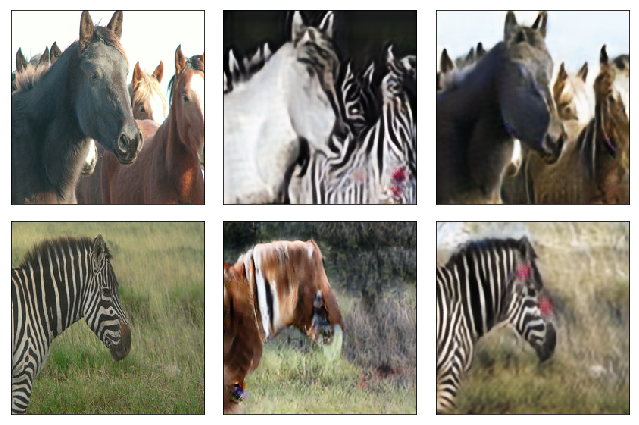

In [37]:
fig,axes = plt.subplots(2,3,figsize=(9,6))
for i,ax in enumerate(axes.flat):
    show_img(test_imgs[i], ax)
fig.tight_layout()

## fin